### keras-retinanet 패키지를 이용하여 이미지와 영상 Object Detection 수행
*  Pretrained된 coco 모델을 로드 하고 이를 이용하여 Object Detection 수행

#### 관련 모듈 import 

In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
%matplotlib inline


# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

Using TensorFlow backend.


#### gpu 환경 설정

In [2]:
# gpu id 값 설정
gpu = 0
setup_gpu(gpu)

#### keras-retinanet으로 pretrained된 coco 모델 다운로드하고 해당 모델을 로드

In [ ]:
# 아래 모델은 https://github.com/fizyr/keras-retinanet/releases 에서 download 받을 수 있음. 
# 해당 모델 h5 파일을 snapshot 디렉토리에 저장 후 retina model의 load_model()을 이용하여 모델 로딩.
# !wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5 

In [3]:
os.path.join('./keras-retinanet', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

'./keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5'

In [4]:
model_path = os.path.join('./keras-retinanet', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

# pretrained coco 모델 파일을 retinanet 모델로 로딩.  
retina_model = models.load_model(model_path, backbone_name='resnet50')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/younggi.kim999/anaconda3/envs/tf115/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#### coco 데이터 세트의 클래스id별 클래스명 지정. 

In [5]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

In [6]:
test_array = np.array([[1,2]])
print(test_array.shape)
expand_array = np.expand_dims(test_array, axis=0)
expand_array.shape

(1, 2)


(1, 1, 2)

#### 원본 이미지를 Object Detection 후에 시각화 표시. 

image shape: (633, 806, 3)
resized image size: (800, 1019, 3) scale: 1.263823064770932

(1, 300, 4) (1, 300) (1, 300)
processing time:  5.977947473526001


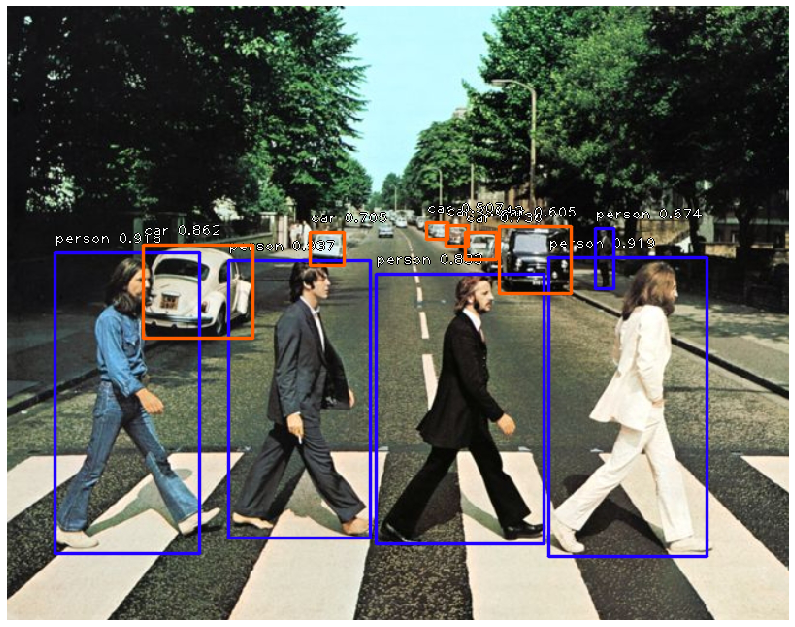

In [7]:
# load image
image = read_image_bgr('../../data/image/beatles01.jpg')
print('image shape:', image.shape)
# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)


# 모델에 입력전에 이미지 사전 처리. keras-retinanet은 image
image = preprocess_image(image)
image, scale = resize_image(image)
print('resized image size:', image.shape, 'scale:', scale)

# 이미지에 대해 Object Detection 수행. 
start = time.time()
boxes, scores, labels = retina_model.predict_on_batch(np.expand_dims(image, axis=0))
print(boxes.shape, scores.shape, labels.shape)
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names_seq[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(14, 14))
plt.axis('off')
plt.imshow(draw)
plt.show()

object detection 처리 시간:  0.10038
이미지 processing 시간:  0.10209


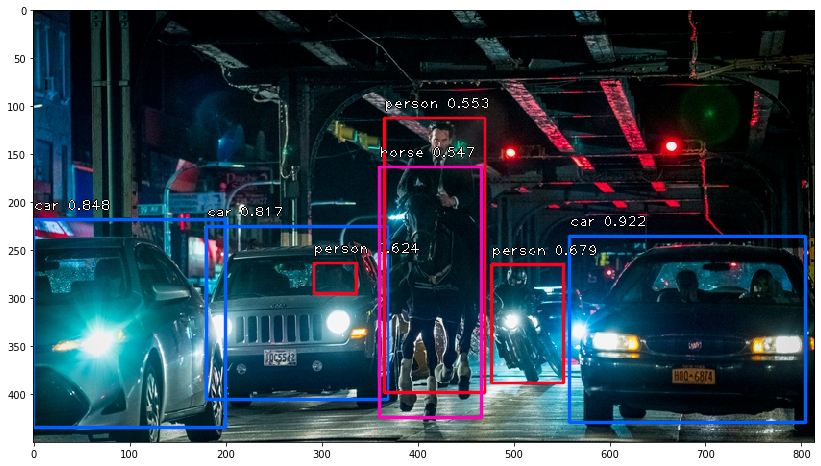

In [13]:
def get_detected_image_retina(model, img_array, use_copied_array, is_print=True):
    
    # copy to draw on
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    img_array = preprocess_image(img_array)
    img_array, scale = resize_image(img_array)
    
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(img_array, axis=0))
    if is_print:
        print("object detection 처리 시간: ", round(time.time() - start,5))
    
    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw_img, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names_seq[label], score)
        draw_caption(draw_img, b, caption)
    
    if is_print:
        print("이미지 processing 시간: ", round(time.time() - start,5))
    
    return draw_img

# image 로드 
img = cv2.imread('../../data/image/john_wick01.jpg')
draw_img = get_detected_image_retina(retina_model, img, use_copied_array=True, is_print=True)
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 14))
plt.imshow(img_rgb)

In [16]:
def detect_video_retina(model, input_path, output_path=""):
    
    start = time.time()
    cap = cv2.VideoCapture(input_path)
    
    codec = cv2.VideoWriter_fourcc(*'XVID')
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    vid_size= (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
    
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    
    while True:
        hasFrame, image_frame = cap.read()
        if not hasFrame:
            print('프레임이 없거나 종료 되었습니다.')
            break

        detected_image = get_detected_image_retina(model,image_frame, use_copied_array=False, is_print=True)
        vid_writer.write(detected_image)
    
    vid_writer.release()
    cap.release()
    print('### Video Detect 총 수행시간:', round(time.time()-start, 5))

In [18]:
detect_video_retina(retina_model, '../../data/video/John_Wick_small.mp4', output_path="../../data/output/John_Wick_small_retina01.avi")

총 Frame 갯수: 58
object detection 처리 시간:  0.08694
이미지 processing 시간:  0.08844
object detection 처리 시간:  0.0851
이미지 processing 시간:  0.08654
object detection 처리 시간:  0.08361
이미지 processing 시간:  0.08487
object detection 처리 시간:  0.08744
이미지 processing 시간:  0.08891
object detection 처리 시간:  0.08241
이미지 processing 시간:  0.08356
object detection 처리 시간:  0.08067
이미지 processing 시간:  0.08214
object detection 처리 시간:  0.07875
이미지 processing 시간:  0.08048
object detection 처리 시간:  0.07968
이미지 processing 시간:  0.08089
object detection 처리 시간:  0.08975
이미지 processing 시간:  0.09157
object detection 처리 시간:  0.08708
이미지 processing 시간:  0.08862
object detection 처리 시간:  0.08095
이미지 processing 시간:  0.08222
object detection 처리 시간:  0.08263
이미지 processing 시간:  0.08374
object detection 처리 시간:  0.0802
이미지 processing 시간:  0.08211
object detection 처리 시간:  0.08262
이미지 processing 시간:  0.08433
object detection 처리 시간:  0.08095
이미지 processing 시간:  0.0827
object detection 처리 시간:  0.08496
이미지 processing 시간:  0.08684
object detec

In [19]:
!gsutil cp ../../data/output/John_Wick_small_retina01.avi gs://my_bucket_dlcv/data/output/John_Wick_small_retina01.avi

Copying file://../../data/output/John_Wick_small_retina01.avi [Content-Type=video/x-msvideo]...
/ [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      


In [20]:
detect_video_retina(retina_model, '../../data/video/Night_Day_Chase.mp4', output_path="../../data/output/Night_Day_Chase_retina01.avi")

총 Frame 갯수: 1383
object detection 처리 시간:  0.35981
이미지 processing 시간:  0.36101
object detection 처리 시간:  0.08053
이미지 processing 시간:  0.08134
object detection 처리 시간:  0.08091
이미지 processing 시간:  0.08187
object detection 처리 시간:  0.07932
이미지 processing 시간:  0.08035
object detection 처리 시간:  0.08067
이미지 processing 시간:  0.08169
object detection 처리 시간:  0.07881
이미지 processing 시간:  0.07991
object detection 처리 시간:  0.08265
이미지 processing 시간:  0.08364
object detection 처리 시간:  0.081
이미지 processing 시간:  0.08211
object detection 처리 시간:  0.08156
이미지 processing 시간:  0.08237
object detection 처리 시간:  0.08041
이미지 processing 시간:  0.08124
object detection 처리 시간:  0.07946
이미지 processing 시간:  0.08092
object detection 처리 시간:  0.08105
이미지 processing 시간:  0.08216
object detection 처리 시간:  0.07962
이미지 processing 시간:  0.08077
object detection 처리 시간:  0.07924
이미지 processing 시간:  0.08031
object detection 처리 시간:  0.08346
이미지 processing 시간:  0.08427
object detection 처리 시간:  0.08323
이미지 processing 시간:  0.08432
object de

object detection 처리 시간:  0.08087
이미지 processing 시간:  0.08174
object detection 처리 시간:  0.08047
이미지 processing 시간:  0.08173
object detection 처리 시간:  0.08052
이미지 processing 시간:  0.08152
object detection 처리 시간:  0.07998
이미지 processing 시간:  0.08101
object detection 처리 시간:  0.08029
이미지 processing 시간:  0.08145
object detection 처리 시간:  0.08119
이미지 processing 시간:  0.08229
object detection 처리 시간:  0.08244
이미지 processing 시간:  0.08394
object detection 처리 시간:  0.08194
이미지 processing 시간:  0.08319
object detection 처리 시간:  0.08233
이미지 processing 시간:  0.08349
object detection 처리 시간:  0.08134
이미지 processing 시간:  0.08246
object detection 처리 시간:  0.08058
이미지 processing 시간:  0.08175
object detection 처리 시간:  0.08139
이미지 processing 시간:  0.08234
object detection 처리 시간:  0.08235
이미지 processing 시간:  0.08315
object detection 처리 시간:  0.0811
이미지 processing 시간:  0.08179
object detection 처리 시간:  0.08148
이미지 processing 시간:  0.08244
object detection 처리 시간:  0.08407
이미지 processing 시간:  0.08505
object detection 처리 시간:  

object detection 처리 시간:  0.08268
이미지 processing 시간:  0.08336
object detection 처리 시간:  0.08629
이미지 processing 시간:  0.08686
object detection 처리 시간:  0.07515
이미지 processing 시간:  0.07591
object detection 처리 시간:  0.07696
이미지 processing 시간:  0.07804
object detection 처리 시간:  0.08177
이미지 processing 시간:  0.08256
object detection 처리 시간:  0.07808
이미지 processing 시간:  0.07926
object detection 처리 시간:  0.07781
이미지 processing 시간:  0.07894
object detection 처리 시간:  0.07668
이미지 processing 시간:  0.07736
object detection 처리 시간:  0.07998
이미지 processing 시간:  0.08012
object detection 처리 시간:  0.08333
이미지 processing 시간:  0.08411
object detection 처리 시간:  0.07734
이미지 processing 시간:  0.07808
object detection 처리 시간:  0.07775
이미지 processing 시간:  0.07856
object detection 처리 시간:  0.07732
이미지 processing 시간:  0.07808
object detection 처리 시간:  0.07617
이미지 processing 시간:  0.07722
object detection 처리 시간:  0.07908
이미지 processing 시간:  0.08033
object detection 처리 시간:  0.07542
이미지 processing 시간:  0.07635
object detection 처리 시간: 

이미지 processing 시간:  0.07619
object detection 처리 시간:  0.07372
이미지 processing 시간:  0.0749
object detection 처리 시간:  0.07465
이미지 processing 시간:  0.07564
object detection 처리 시간:  0.07313
이미지 processing 시간:  0.07423
object detection 처리 시간:  0.07369
이미지 processing 시간:  0.07457
object detection 처리 시간:  0.07565
이미지 processing 시간:  0.0767
object detection 처리 시간:  0.07585
이미지 processing 시간:  0.07674
object detection 처리 시간:  0.07423
이미지 processing 시간:  0.07527
object detection 처리 시간:  0.07698
이미지 processing 시간:  0.07826
object detection 처리 시간:  0.07489
이미지 processing 시간:  0.07604
object detection 처리 시간:  0.07558
이미지 processing 시간:  0.0767
object detection 처리 시간:  0.07445
이미지 processing 시간:  0.07558
object detection 처리 시간:  0.07804
이미지 processing 시간:  0.07943
object detection 처리 시간:  0.08012
이미지 processing 시간:  0.0814
object detection 처리 시간:  0.07823
이미지 processing 시간:  0.07956
object detection 처리 시간:  0.07896
이미지 processing 시간:  0.08056
object detection 처리 시간:  0.07772
이미지 processing 시간:  0.07905


object detection 처리 시간:  0.08393
이미지 processing 시간:  0.08444
object detection 처리 시간:  0.08425
이미지 processing 시간:  0.08502
object detection 처리 시간:  0.08225
이미지 processing 시간:  0.0833
object detection 처리 시간:  0.08079
이미지 processing 시간:  0.08171
object detection 처리 시간:  0.08349
이미지 processing 시간:  0.08426
object detection 처리 시간:  0.0829
이미지 processing 시간:  0.08351
object detection 처리 시간:  0.08352
이미지 processing 시간:  0.08402
object detection 처리 시간:  0.08494
이미지 processing 시간:  0.0859
object detection 처리 시간:  0.08276
이미지 processing 시간:  0.08393
object detection 처리 시간:  0.08193
이미지 processing 시간:  0.08259
object detection 처리 시간:  0.08304
이미지 processing 시간:  0.08383
object detection 처리 시간:  0.08522
이미지 processing 시간:  0.08633
object detection 처리 시간:  0.08327
이미지 processing 시간:  0.08433
object detection 처리 시간:  0.08305
이미지 processing 시간:  0.08404
object detection 처리 시간:  0.08641
이미지 processing 시간:  0.08725
object detection 처리 시간:  0.08626
이미지 processing 시간:  0.08731
object detection 처리 시간:  0.

이미지 processing 시간:  0.07622
object detection 처리 시간:  0.07214
이미지 processing 시간:  0.07313
object detection 처리 시간:  0.07193
이미지 processing 시간:  0.0727
object detection 처리 시간:  0.07212
이미지 processing 시간:  0.07273
object detection 처리 시간:  0.07602
이미지 processing 시간:  0.07669
object detection 처리 시간:  0.07672
이미지 processing 시간:  0.0776
object detection 처리 시간:  0.07263
이미지 processing 시간:  0.07326
object detection 처리 시간:  0.07634
이미지 processing 시간:  0.07732
object detection 처리 시간:  0.07367
이미지 processing 시간:  0.07492
object detection 처리 시간:  0.07345
이미지 processing 시간:  0.07459
object detection 처리 시간:  0.07569
이미지 processing 시간:  0.07689
object detection 처리 시간:  0.07267
이미지 processing 시간:  0.07376
object detection 처리 시간:  0.07424
이미지 processing 시간:  0.07501
object detection 처리 시간:  0.07228
이미지 processing 시간:  0.07323
object detection 처리 시간:  0.07333
이미지 processing 시간:  0.07441
object detection 처리 시간:  0.07386
이미지 processing 시간:  0.07485
object detection 처리 시간:  0.07296
이미지 processing 시간:  0.0736

object detection 처리 시간:  0.08076
이미지 processing 시간:  0.08208
object detection 처리 시간:  0.07924
이미지 processing 시간:  0.08076
object detection 처리 시간:  0.08393
이미지 processing 시간:  0.08549
object detection 처리 시간:  0.08261
이미지 processing 시간:  0.08407
object detection 처리 시간:  0.07709
이미지 processing 시간:  0.07818
object detection 처리 시간:  0.07722
이미지 processing 시간:  0.07825
object detection 처리 시간:  0.07994
이미지 processing 시간:  0.08113
object detection 처리 시간:  0.08069
이미지 processing 시간:  0.08174
object detection 처리 시간:  0.07717
이미지 processing 시간:  0.07803
object detection 처리 시간:  0.07774
이미지 processing 시간:  0.07908
object detection 처리 시간:  0.07851
이미지 processing 시간:  0.07959
object detection 처리 시간:  0.07886
이미지 processing 시간:  0.07966
object detection 처리 시간:  0.08155
이미지 processing 시간:  0.08264
object detection 처리 시간:  0.07946
이미지 processing 시간:  0.08051
object detection 처리 시간:  0.08125
이미지 processing 시간:  0.08233
object detection 처리 시간:  0.07951
이미지 processing 시간:  0.08065
object detection 처리 시간: 

object detection 처리 시간:  0.08467
이미지 processing 시간:  0.08581
object detection 처리 시간:  0.08705
이미지 processing 시간:  0.08816
object detection 처리 시간:  0.08501
이미지 processing 시간:  0.08573
object detection 처리 시간:  0.08671
이미지 processing 시간:  0.08757
object detection 처리 시간:  0.08686
이미지 processing 시간:  0.08749
object detection 처리 시간:  0.08798
이미지 processing 시간:  0.08815
object detection 처리 시간:  0.08136
이미지 processing 시간:  0.08197
object detection 처리 시간:  0.07953
이미지 processing 시간:  0.0803
object detection 처리 시간:  0.08527
이미지 processing 시간:  0.08591
object detection 처리 시간:  0.08042
이미지 processing 시간:  0.0806
object detection 처리 시간:  0.08229
이미지 processing 시간:  0.08291
object detection 처리 시간:  0.07788
이미지 processing 시간:  0.07859
object detection 처리 시간:  0.08434
이미지 processing 시간:  0.08493
object detection 처리 시간:  0.08516
이미지 processing 시간:  0.08593
object detection 처리 시간:  0.08
이미지 processing 시간:  0.0809
object detection 처리 시간:  0.07982
이미지 processing 시간:  0.08055
object detection 처리 시간:  0.079

object detection 처리 시간:  0.07538
이미지 processing 시간:  0.07685
object detection 처리 시간:  0.0732
이미지 processing 시간:  0.0741
object detection 처리 시간:  0.0739
이미지 processing 시간:  0.07536
object detection 처리 시간:  0.07241
이미지 processing 시간:  0.07387
object detection 처리 시간:  0.07372
이미지 processing 시간:  0.07461
object detection 처리 시간:  0.07029
이미지 processing 시간:  0.07107
object detection 처리 시간:  0.07033
이미지 processing 시간:  0.07117
object detection 처리 시간:  0.07257
이미지 processing 시간:  0.07314
object detection 처리 시간:  0.07459
이미지 processing 시간:  0.07521
object detection 처리 시간:  0.07207
이미지 processing 시간:  0.07263
object detection 처리 시간:  0.07282
이미지 processing 시간:  0.07369
object detection 처리 시간:  0.07696
이미지 processing 시간:  0.07773
object detection 처리 시간:  0.07511
이미지 processing 시간:  0.07596
object detection 처리 시간:  0.07247
이미지 processing 시간:  0.0731
object detection 처리 시간:  0.07781
이미지 processing 시간:  0.07856
object detection 처리 시간:  0.0793
이미지 processing 시간:  0.07995
object detection 처리 시간:  0.08

object detection 처리 시간:  0.08279
이미지 processing 시간:  0.08356
object detection 처리 시간:  0.08033
이미지 processing 시간:  0.0811
object detection 처리 시간:  0.08261
이미지 processing 시간:  0.08357
object detection 처리 시간:  0.0817
이미지 processing 시간:  0.08259
object detection 처리 시간:  0.08461
이미지 processing 시간:  0.08561
object detection 처리 시간:  0.08337
이미지 processing 시간:  0.08446
object detection 처리 시간:  0.08628
이미지 processing 시간:  0.08756
object detection 처리 시간:  0.08773
이미지 processing 시간:  0.08888
object detection 처리 시간:  0.0865
이미지 processing 시간:  0.0877
object detection 처리 시간:  0.0827
이미지 processing 시간:  0.08377
object detection 처리 시간:  0.08297
이미지 processing 시간:  0.08406
object detection 처리 시간:  0.08368
이미지 processing 시간:  0.08474
object detection 처리 시간:  0.08168
이미지 processing 시간:  0.0829
object detection 처리 시간:  0.08323
이미지 processing 시간:  0.08427
object detection 처리 시간:  0.08317
이미지 processing 시간:  0.08408
object detection 처리 시간:  0.08319
이미지 processing 시간:  0.08422
object detection 처리 시간:  0.083

object detection 처리 시간:  0.07456
이미지 processing 시간:  0.07471
object detection 처리 시간:  0.07435
이미지 processing 시간:  0.0745
object detection 처리 시간:  0.07485
이미지 processing 시간:  0.07501
object detection 처리 시간:  0.07478
이미지 processing 시간:  0.07495
object detection 처리 시간:  0.07373
이미지 processing 시간:  0.07397
object detection 처리 시간:  0.07312
이미지 processing 시간:  0.07331
object detection 처리 시간:  0.07468
이미지 processing 시간:  0.07487
object detection 처리 시간:  0.07388
이미지 processing 시간:  0.07404
object detection 처리 시간:  0.07375
이미지 processing 시간:  0.07395
object detection 처리 시간:  0.07366
이미지 processing 시간:  0.07383
object detection 처리 시간:  0.07482
이미지 processing 시간:  0.07502
object detection 처리 시간:  0.07281
이미지 processing 시간:  0.07298
object detection 처리 시간:  0.07412
이미지 processing 시간:  0.07429
object detection 처리 시간:  0.07581
이미지 processing 시간:  0.07605
object detection 처리 시간:  0.07439
이미지 processing 시간:  0.07459
object detection 처리 시간:  0.0733
이미지 processing 시간:  0.0735
object detection 처리 시간:  0.

In [21]:
!gsutil cp ../../data/output/Night_Day_Chase_retina01.avi gs://my_bucket_dlcv/data/output/Night_Day_Chase_retina01.avi

Copying file://../../data/output/Night_Day_Chase_retina01.avi [Content-Type=video/x-msvideo]...
/ [1 files][ 32.1 MiB/ 32.1 MiB]                                                
Operation completed over 1 objects/32.1 MiB.                                     
